### Daily R value derived from number of cases reported in LA county
Mehrdad Kiamari, Bhaskar Krishnamachari - June 2020

To monitor the severity of any epidemic, it is crucial to look at $R_t$ which is a value representing the effective reproduction number (the number of individuals who are infected per infectious individual at time $t$) of the disease. 

Regarding $R_t$, the epidemic will exponentially grow among the population when $R_t >> 1$. However, the epidemic sloowly disappear as $R_t<1$. Since restirctions would eventually impactts $R_t$, this measure can guide authorities to take appropriate actions regarding tightening or loosing restrictions for the sake of having economic prosperity and human safety.   

In this code, we aim at estimating daily R value of COVID-19 in LA county. Our approach is universal and can be utilized for any area. We use SIR model, i.e.

$$
\begin{align}
\frac{dS}{dt} &= -\beta \frac{SI}{N}\\
\frac{dI}{dt} &= +\beta \frac{SI}{N} - \sigma I\\
\frac{dR}{dt} &= \sigma I
\end{align}
$$

where $S$, $I$, and $R$ represent the number of Susceptible, Infected, and Recovered people in a population size of $N$. Regarding the parameter $\sigma = \frac{1}{D_i}$, $D_i$ represents the average infectious days.

As far as $R$ is concerned, it is equal to $\frac{\beta}{\sigma}$. Our idea is to estimate $\beta$ at each time from the above differential equation which involves $\frac{dI}{dt}$, then calculate the corresponding $R$.

In [1]:
import json
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
from matplotlib.colors import hsv_to_rgb
from itertools import combinations
import pandas as pd
from scipy.optimize import fsolve
import datetime as dt 

from gekko import GEKKO
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

Create a dictionary consisting of communities and their population as keys and values, respectively. 

In [2]:
from pathlib import Path
#home = str(Path.home())
#home += "/covid19_risk_estimation/data/population.json"
#home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/population.json"
home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/populationBog.json"
with open(home) as json_file_pop:
    data_population = json.load(json_file_pop)

Function to check if the communitiy exists in the dictionary for population

In [3]:
def check_if_community_is_in_dic_pop(community_name):
    #home = str(Path.home())
    #home += "/covid19_risk_estimation/data/population_whole_county.json"
    #home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/population_whole_county.json"
    home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/populationBog.json"
    with open(home) as json_file_pop:
        data_population = json.load(json_file_pop)
        temp = [val for key,val in data_population.items() if community_name == key.strip().split('--')[0]]
        if len(temp)==1:
            return True
        return False

In [4]:
def calculating_approx_R_for_community(sigma,ave_k):
    vec_I,population = self.confirmed_daily, self.pop
    c = len(vec_I)
    matrix_I = vec_I[np.newaxis,:]
    beta_SIR,R= np.zeros((c-1,)),np.zeros((c-1,))
    for time in range(c-1):
        clear_output(wait=True)
        next_I,curr_I,N = ave_k*vec_I[time+1],ave_k*vec_I[time],population
        print("curr", curr_I, "next", next_I)
#         if next_I>curr_I:
#             if next_I != 0 and curr_I != 0 and next_I != curr_I:
#                 m = GEKKO()             # create GEKKO model
#                 beta = m.Var(value=.2)      # define new variable, initial value=0
#                 m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0]) # equations
#                 m.solve(disp=False)     # solve
#                 output = beta.value[0]
#             else:
#                 if curr_I != 0:
#                     output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
#                 else:
#                     output = 0
#         else:
        if curr_I != 0:
            output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
        else:
            output = 0

        beta_SIR[time] = max(0,output)
        #beta_SIR[time] = max(0,solve_beta_for_single_time_exponential(matrix_I[0,time+1],matrix_I[0,time],sigma,population,0) )
        self.infection_rate[time] = beta_SIR[time] / sigma
        #R[time] = beta_SIR[time] / sigma
        #risk[time] = max((10000)*R[time]*vec_I[time]*ave_k/(1.0*population),0)
    clear_output(wait=True)

    #return R

### Side Class and Functions

Each community is an object with few attributes such as name, number of daily or cumulative cases, etc.


In [5]:
class community:
	def __init__(self,name,actual_name,Today_date):
		self.name = name
		self.Today_date = Today_date
		self.actual_name = actual_name # for displaying part of figures
		# cumulative total
		self.confirmed = np.zeros(len(range(26, self.Today_date)),dtype=int)
		self.confirmed_daily = np.zeros(len(range(26, self.Today_date)),dtype=int)

		self.infection_rate = np.zeros(len(range(26, self.Today_date-1)))
		self.risk = np.zeros(len(range(26, self.Today_date-1)))
		self.pop = 0
	def set_population(self,val):        
		self.pop = val
	def smoothing(self,n):        
		self.confirmed_daily = mov_ave(self.confirmed_daily,n,100) 
	def calculating_approx_R_and_risk_for_community(self,sigma,ave_k):
		matrix_I,population = self.confirmed_daily, self.pop
		c = matrix_I.shape[1]
		beta_SIR,R= np.zeros((c-1,)),np.zeros((c-1,))
		for time in range(c-1):
			#clear_output(wait=True)
			next_I,curr_I,N = ave_k*matrix_I[0,time+1],ave_k*matrix_I[0,time],self.pop
			#print("curr", curr_I, "next", next_I)
			if curr_I != 0:
				output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
			else:
				output = 0
			beta_SIR[time] = max(0,output)
			self.infection_rate[time] = beta_SIR[time] / sigma
			self.risk[time]= (10000.0*self.infection_rate[time])*(curr_I)/N
		#clear_output(wait=True) 

#############################################################
	# for adding new entry for each community on every day 	
	def check_validity_new_entry(self,day):
		index = day - 26
		if index == 0:
			return True
		else:
			if self.confirmed[index] >= self.confirmed[index-1]:
				return True
			return False		
	def update_confirmed_cases(self,day):
		index = day - 26
		while index != 0:
			if self.confirmed[index] < self.confirmed[index-1]:
				self.confirmed[index-1] = self.confirmed[index]
			index -= 1
	def addnumber(self,day, number):
		index = day - 26
		self.confirmed[index] = number
		status_validity_of_entry = self.check_validity_new_entry(day)
		if not status_validity_of_entry:
			self.update_confirmed_cases(day)

	# return the confirmed cases (either daily or cumulative) for each community		
	def plot_info(self,type_plot):
		output = np.zeros(len(range(26, self.Today_date)),dtype=int)
		for index,i in enumerate(list(range(26, self.Today_date))):
			# for daily
			if type_plot == 'daily':
				# if i in self.dic_confirmed.keys():
				# 	output[index] =  self.dic_confirmed[i]
				# else:
				# 	output[index] = 0
				output = self.confirmed_daily
			# for cumulative
			else:
				output = self.confirmed
		return output	

# get population for top selected communities    
# def get_population_vec(list_communities):
# 	with open('population_whole_county.json') as json_file_pop:
# 		data_old = json.load(json_file_pop)
# 		data = {k.lower().strip().replace(' ',''):v for k,v in data_old.items()}
# 		output_list = []
# 		for communiuty_obj in list_communities:
# 			#temp = [val for key,val in data.items() if communiuty_obj.actual_name == key.strip().split('--')[0]]
# 			temp = [val for key,val in data.items() if communiuty_obj.name in key]

# 			if temp :
# 		 		output_list.append(int(temp.pop().strip()))
# 		if len(output_list) == len(list_communities):
# 			output = np.asarray(output_list)
# 		else:
# 			return -1
# 			#raise NameError('The name of one of communities has NOT been found!')	
# 		return output
    
    
  
        



# create matrix for number of infections for top selected communities    
def create_matrix(list_selected_communities,type_plot,til_date):
	matrix_I =  np.zeros((len(list_selected_communities),til_date ))
	for i,communiuty_obj in  enumerate(list_selected_communities):
		I_s_this_community_obj = communiuty_obj.plot_info(type_plot)[:til_date]
		for j,infected_at_this_day in enumerate(I_s_this_community_obj):
			 matrix_I[i,j] = infected_at_this_day
	return matrix_I	 

# matrix I is supposed to be increasing for each community, so we fix any drop by this function
def fix_matrix_I(matrix_I):
    output = np.zeros_like(matrix_I)
    output[:,0] = matrix_I[:,0]
    r,c = matrix_I.shape[0], matrix_I.shape[1]
    for ind_r in range(r):
        for ind_c in range(1,c):
            if matrix_I[ind_r,ind_c] < matrix_I[ind_r,ind_c-1]:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c-1]
            else:
                output[ind_r,ind_c] = matrix_I[ind_r,ind_c]
    return output            

In [6]:
#home = str(Path.home())
#home += "/covid19_risk_estimation/software/raw_python_scripts/processed_population.csv"
#home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/processed_population_fixedmissing.csv"
home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/processed_populationBog.csv"
data_pop = pd.read_csv(home)
dic_pop_new = {}
for ind in data_pop.index: 
	# getting name of comm and do regular expressions
	city = data_pop['Region'][ind]
	processed_city = city.strip().lower().replace(' ','')
	prefixex = ['cityof','losangeles-','unincorporated-']
	for word in prefixex:
		name_of_community = processed_city.replace(word,'')
	# get day
	pop = data_pop['Population'][ind]
	dic_pop_new[name_of_community]=pop
        
def get_population_vec(list_communities):
	output_list = []
	#dic_pop = {}
		#print(pop,type(pop))
	for comm_obj in list_communities:    
		if comm_obj.name in dic_pop_new.keys():
			output_list.append(dic_pop_new[name_of_community])
		else:
			print(comm_obj.name)            
	if len(output_list) == len(list_communities):
		output = np.asarray(output_list)
	else:
		return -1
	return output  

In [7]:
# def find_intial_non_zero_val_Infection(ref_matrix_I):
# # output : non-zero values for each city    
# 	vec = np.zeros((ref_matrix_I.shape[0],))
# 	for city in range(ref_matrix_I.shape[0]):
# 		for time in range(ref_matrix_I.shape[1]):
# 			if ref_matrix_I[city,time] != 0:
# 				vec[city] = ref_matrix_I[city,time]
# 				break
# 	return vec

# def function_for_solver(z,*data):
#     next_I,curr_I,sigma,N = data
#     beta = z
    
#     F = 0
#     F = ((1/(beta-sigma))*np.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*np.log(curr_I/((beta-sigma)-beta*curr_I/N))) - 1.0 # equations

#     return F   
def solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta):      
	if curr_I != 0:
		output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
	else:
		output = prev_beta
	return output 	
last_beta_1 = 0
def solve_beta_for_single_time_exponential(next_I,curr_I,sigma,N,prev_beta):
	global last_beta_1
	print("curr", curr_I, "next", next_I)
	if next_I>curr_I:
		if next_I != 0 and curr_I != 0 and next_I != curr_I:
			m = GEKKO()             # create GEKKO model
			m.options.SOLVER=1
			beta = m.Var(value=.2)      # define new variable, initial value=0
			m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0]) # equations
			try:     
				m.solve(disp=False)     # solve
				output = beta.value[0]
				last_beta_1 = output
			except:
				output = last_beta_1
		else:
			output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)
	else:
		output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)	
#################################
# 	data = (next_I,curr_I,sigma,N)
# 	beta_guess = .2
# 	output = fsolve(function_for_solver, beta_guess, args=data)
#################################
# 	output = solve_beta_for_single_time_polynomial(next_I,curr_I,sigma,N,prev_beta)	
	return output 
def calculating_beta(matrix_I,vec_population,sigma,Today_date, name_top_selected_communities,type_solver):
	r,c = matrix_I.shape[0] , matrix_I.shape[1]
	matrix_beta = np.zeros((r,c-1))
	R = np.zeros((r,c-1))
	for city in range(r):
		prev_beta = 0
		for time in range(c-1):
			clear_output(wait=True)  
			print("beta for city:",city)
			if type_solver == 'exact':
				matrix_beta[city,time] = max(0,solve_beta_for_single_time_exponential(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city],prev_beta) )
			else:
				matrix_beta[city,time] = max(0,solve_beta_for_single_time_polynomial(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city],prev_beta) )
			prev_beta = matrix_beta[city,time]
			R[city,time] = matrix_beta[city,time] / sigma

	clear_output(wait=True) 
# 	print("DONJE")

	return matrix_beta

def calculate_R_margin_for_single_time(next_I,curr_I,sigma,N):
    # D is ave recovery time in days
    if curr_I != 0: 
        D = 1/sigma;
        std= 4.5
        sigma = 1/(D-std) 
        down = max((next_I- curr_I)/( sigma*(curr_I- (1/N)*curr_I**2) ) + (1/(1-curr_I/N)),0)

        factor = 10
        next_I, curr_I = factor*next_I, factor*curr_I
        sigma = 1/(D+std) 
        up = max((next_I- curr_I)/( sigma*(curr_I- (1/N)*curr_I**2) ) + (1/(1-curr_I/N)),0)
    else:
        down, up = 0, 0
    return down,up

def calculating_R_marigins(matrix_I,vec_population,sigma,Today_date, name_top_selected_communities):
	r,c = matrix_I.shape[0] , matrix_I.shape[1]
#	matrix_beta = np.zeros((r,c-1))
	U = np.zeros((r,c-1))
	D = np.zeros((r,c-1))
	for city in range(r):
		for time in range(c-1):
			#clear_output(wait=True)             
			#print("Margin for city",city)
			margin = calculate_R_margin_for_single_time(matrix_I[city,time+1],matrix_I[city,time],sigma,vec_population[city]) 
			D[city,time],U[city,time] = margin[0],margin[1]


# 	clear_output(wait=True) 
# 	print("Margin len",D.shape[1],U.shape[1] )

	return D,U
    

### Load CSV File

In [8]:
#home = str(Path.home())
#home += "/covid19_risk_estimation/data/Covid-19.csv"
#home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/Covid-19.csv"
home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Covid-19-Bog_Acc.csv"
states1 = pd.read_csv(home, usecols=[0,1,4],
                     index_col=['Region', 'Time Stamp'],
                     parse_dates=['Time Stamp'],
                     squeeze=True).sort_index()
states = states1.groupby(['Region', 'Time Stamp']).sum()
states.head()
#print(states['Melrose']['2020-03-16'])

Region          Time Stamp
antonio nariño  2020-02-26    0
                2020-02-27    0
                2020-02-28    0
                2020-02-29    0
                2020-03-01    0
Name: Number of cases, dtype: int64

### Create DataFrame 
Make DataFrame for R

In [9]:
def create_dataframe_for_R(ind_city,matrix_beta,sigma,U,D):  
    r,c = matrix_beta.shape[0],matrix_beta.shape[1]
    data={}
    data['R'] = matrix_beta[ind_city,:]/sigma
    data['Upper'] = U[ind_city,:]
    data['Lower'] = D[ind_city,:]
    #print(len(data['R']),len(data['Upper']),len(data['Lower']))
    data['Time Stamp'] = pd.date_range(start='2020-02-26', periods=c)    
    dataset = pd.DataFrame(data)
    dataset.set_index(['Time Stamp'], inplace=True)    
    #print(dataset)
    return dataset    

In [10]:
def create_dataframe_for_Risk(ind_city,risk,U,D):  
    r,c = risk.shape[0],risk.shape[1]
    data={}
    data['R'] = risk[ind_city,:]
    data['Upper'] = U[ind_city,:]
    data['Lower'] = D[ind_city,:]
    #print(len(data['R']),len(data['Upper']),len(data['Lower']))
    data['Time Stamp'] = pd.date_range(start='2020-02-26', periods=c)    
    dataset = pd.DataFrame(data)
    dataset.set_index(['Time Stamp'], inplace=True)    
    #print(dataset)
    return dataset    

### Plot Func for R along its confidence interval

In [11]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(str(state_name))
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['R'].index.get_level_values('Time Stamp')
    values = result['R'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Lower'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['Upper'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-26'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,14.0)
    ax.set_xlim(pd.Timestamp('2020-02-26'), result.index.get_level_values('Time Stamp')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')


    


### Moving Average for Smoothing

In [12]:
 def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

#  def movingaverage (values, window):
#     weights = np.repeat(1.0, window)/window
#     sma = np.convolve(values, weights)
#     print("l",len(sma))
#     print(len(values))
#     print(window)
#     import pdb;pdb.set_trace()
#     return sma

def moving_ave_on_matrix(matrix_I,n):
    #n=7      
    padded_I = np.zeros((matrix_I.shape[0],matrix_I.shape[1] + n-1 ))

    padded_I[:,(n-1)//2:-(n-1)//2]=matrix_I
    for city in range(matrix_I.shape[0]):
        matrix_I[city,:] = movingaverage(padded_I[city,:],n)
    return matrix_I

### Considering a Gaussian Distribution for both parameter $D_I$ (recovery time) and factor $k$ (ratio of actual confirmed cases to reported ones)
Setting the mean and var of PDFs

In [13]:
mean_D = 7.5
var_D = 3.0#4.5

min_k_value = 1.0
max_k_value = 5.0
mean_k = .5*(min_k_value+max_k_value)
var_k = ((max_k_value-min_k_value)/6)**2

### PDFs of parameters $D_I$, $k$, and infection rate $R_t$ 

In [14]:
def pdf_normal(x,mean,var):
	return (1/np.sqrt(2*np.pi*var))*np.exp(-.5*(1/var)*((x-mean)**2))

In [15]:
def pdf_k(x,min_k_value,max_k_value):
	mean = .5*(min_k_value+max_k_value)
	var = ((max_k_value-min_k_value)/6)**2
	return (1/np.sqrt(2*np.pi*var))*np.exp(-.5*(1/var)*((x-mean)**2))

def pdf_k_uniform(x,min_k_value,max_k_value):
	if min_k_value <= x and x <= max_k_value:
		return 1/(max_k_value-min_k_value)
	return 0

# def convert_into_input_argument_pdf_k(x,next_I,curr_I,N,r):
# 	return (N/curr_I)*(1-(1+((next_I-curr_I)/curr_I)/x)/r)
# def pdf_R_for_single_r(next_I,curr_I,N,r,mean_sigma,var_sigma,min_k_value,max_k_value):
# 	#range_sigma = np.arange(1/(7.5+4.5),1/(7.5-4.5),0.01)
# 	range_sigma = np.arange(-200,200,0.01)    
# 	input_argument_pdf_k = list(map(lambda x:convert_into_input_argument_pdf_k(x,next_I,curr_I,N,r),range_sigma))
# 	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),input_argument_pdf_k))
# 	val_pdf_sigma = list(map(lambda x:pdf_normal(x,mean_sigma,var_sigma),range_sigma))
# 	coeff = list(map(lambda x:(N/curr_I)-convert_into_input_argument_pdf_k(x,next_I,curr_I,N,r),range_sigma))
# 	print("INPUT K",input_argument_pdf_k)
# 	#plt.plot(range(len(range_sigma)),val_pdf_sigma)
# 	#plt.plot(range(len(range_sigma)),val_pdf_k,'r')
# 	#plt.plot(range(len(range_sigma)),coeff,'g')
# 	#plt.show()
# 	#import pdb;pdb.set_trace()

def pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value):
	#range_sigma = np.arange(1/(7.5+4.5),1/(7.5-4.5),0.01)
	a , b = curr_I/N , (next_I-curr_I)/curr_I   
	meanD, varD = mean_D,var_D
	step_z = 0.01    
	z = np.arange(0,200,step_z)    
	input_argument_pdf_sigma = list(map(lambda x:(r*(1-x*a)-1)/b,z))
	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),z))
	val_pdf_sigma = list(map(lambda x:pdf_normal(x,meanD,varD),input_argument_pdf_sigma))
	#coeff = list(map(lambda x:np.absolute((b*(1-x*a))/((1-r*(1-x*a))**2)),z))
	coeff = list(map(lambda x:np.absolute((1-x*a)/b),z))
	#print("INPUT K",input_argument_pdf_k)
	#plt.plot(range(len(range_sigma)),val_pdf_sigma)
	#plt.plot(range(len(range_sigma)),val_pdf_k,'r')
	#plt.plot(range(len(range_sigma)),coeff,'g')
	#plt.show()
	#import pdb;pdb.set_trace()
    
    
	#print("f_R(r)",r,sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k))*step_z) 
	#print("f_R(r)")    
	return sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k)*step_z)

In [16]:
def cal_delta(next_I,curr_I,N,ave_r,desired_prob,mean_sigma,var_sigma,min_k_value,max_k_value):
    prob, index, dr = 0,0,0.01
#     #print("--",MIN_R_range,Max_R_range)
#     range_r = np.arange(0,10,.1)

#     y = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
#     plt.plot(range_r,y)
#     print("sum pdf",sum(y))
#     plt.show()
#     return 0
    r = ave_r
    prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    
    ind_left ,ind_right = 1,1
    while prob < desired_prob:
#         if index ==0:
#             r = ave_r
#             prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
#             index +=1
#         else:
        

        r = ave_r + ind_right*dr
        prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        ind_right += 1
        #if ave_r - ind_left*dr > 0:
        r = ave_r - ind_left*dr
        prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        ind_left +=1
        #print("-->",ind_right,ind_left,prob)
    print("done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
    return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr
        

In [17]:
from scipy import stats
from scipy.stats import norm

In [18]:
def pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mu_D,var_D,mu_k,var_k):
    k1 , k2 = .01 , N/curr_I
    a , b = curr_I/N , np.absolute((next_I-curr_I)/curr_I)
    alpha_0 = (((-(1/b)+(r/b)-mu_D)**2)/(2*var_D))+((mu_k**2)/(2*var_k)) 
    alpha_1 = -(((-(1/b)+(r/b)-mu_D)*(r*a/b))/(var_D))-((mu_k)/(var_k)) 
    alpha_2 = (((r*a/b)**2)/(2*var_D))+1/(2*var_k)
    beta_0 , beta_1 = 1/b , -a/b
    const = np.exp(-(alpha_0-(alpha_1**2)/(4*alpha_2)))/(2*np.pi*np.sqrt(var_D*var_k))
    mu_c , var_c = -alpha_1/(2*alpha_2) , 1/(2*alpha_2)
    #step_z = 0.1
    #z = np.arange(0,200,step_z)  
    #f1 = list(map(lambda x: np.exp(-(alpha_0+alpha_1*x+alpha_2*x*x)),z))
    #f2= list(map(lambda x:beta_0+beta_1*x,z))
    #return sum(np.multiply(f1,f2))*step_z
    output_term1 = beta_1*var_c*const * (np.exp(-((k1-mu_c)**2)/(2*var_c))-np.exp(-((k2-mu_c)**2)/(2*var_c)))
    output_term2 = (beta_1*mu_c+beta_0)*const*(np.sqrt(2*np.pi*var_c))*(norm.cdf((k2-mu_c)/np.sqrt(var_c))-norm.cdf((k1-mu_c)/np.sqrt(var_c)))
    return output_term1+output_term2
    #(beta_0 + mu_c*beta_1)*const*(np.sqrt(2*np.pi*var_c))#

    #f1 = -beta_1*var_c*(np.exp(-((k2-mu_c)**2)/(2*var_c))) + (beta_1*mu_c+beta_0)*np.sqrt(2*np.pi*var_c)*norm.cdf((k2-mu_c)/np.sqrt(var_c))
    #f2 = -beta_1*var_c*(np.exp(-((k2-mu_c)**2)/(2*var_c))) + (-beta_1*mu_c-beta_0)*np.sqrt(2*np.pi*var_c)*(1-norm.cdf((k2-mu_c)/np.sqrt(var_c)))
    #return (f1+f2)   

In [19]:
def cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,desired_prob,mean_D,var_D,mean_k,var_k):
    if ave_r == 0:
        return 0,0
    prob, index, dr = 0,0,0.01
#     #print("--",MIN_R_range,Max_R_range)
#     range_r = np.arange(0,10,.1)

#     y = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
#     plt.plot(range_r,y)
#     print("sum pdf",sum(y))
#     plt.show()
#     return 0
    r = ave_r
    #prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    prob = pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
    counter_exceed = 1
    ind_left ,ind_right = 1,1
    while prob < desired_prob and counter_exceed<1000:
#         if index ==0:
#             r = ave_r
#             prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
#             index +=1
#         else:
        

        r = ave_r + ind_right*dr
        #prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        prob += pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
        ind_right += 1
        if ave_r - ind_left*dr > 0:
            r = ave_r - ind_left*dr
            #prob += pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
            prob += pdf_R_both_D_and_k_normal(r,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k)*dr
            ind_left +=1
        #print("-->",ind_right,ind_left,prob)
        counter_exceed +=1
        if counter_exceed==1000:
            return .5*ave_r,2*ave_r
            #print("-----done!","range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
            #return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr
    print("-----done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
    return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr

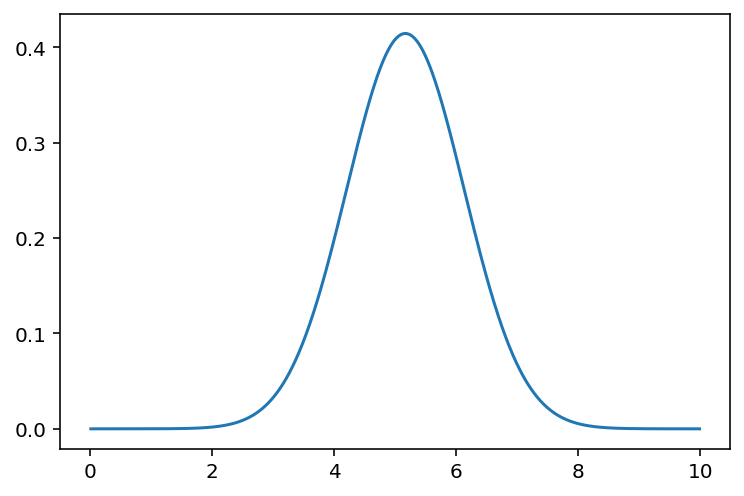

In [20]:
range_r = np.arange(0.01,10,0.01)
next_I, curr_I , N, sigma = 70.0,45.0,7800000.0,1.0/7.5
val_pdf_r = list(map(lambda x:pdf_R_both_D_and_k_normal(x,next_I,curr_I,N,sigma,mean_D,var_D,mean_k,var_k),range_r))
#val_pdf_r = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
plt.plot(range_r,val_pdf_r)
plt.show()

### calculate AVERAGE $R_t$

In [21]:
def calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value):
    a = curr_I/N
    b = (next_I-curr_I)/curr_I
    #step_sigma = 0.01
    step_k = .01
    #range_sigma = np.arange(mean_sigma-3*np.sqrt(var_sigma),mean_sigma+3*np.sqrt(var_sigma),step_sigma)
    range_k = np.arange(min_k_value,max_k_value,step_k)
    # 
    g1 = list(map(lambda x:(1/(1-x*a)),range_k))
    pdf1 = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),range_k))
    exp1 = sum(np.multiply(g1,pdf1))*step_k
    
    exp2 = 1+ b*mean_D
#     g2 = list(map(lambda x:1+((next_I-curr_I)/(x*curr_I)),range_sigma))
#     pdf2 = list(map(lambda x:pdf_normal(x,mean_sigma,var_sigma),range_sigma))
#     exp2 = sum(np.multiply(g2,pdf2))*step_sigma
    
    print("AVE R",max(exp1*exp2,0))
    return max(exp1*exp2,0)

In [22]:
def calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value):
#     ave_k = (min_k_value+max_k_value)/2
#     curr_I = curr_I/ave_k
#     next_I = next_I/ave_k
    
    a = curr_I/N
    b = (next_I-curr_I)/curr_I
    #step_sigma = 0.01
    step_k = .01
    #range_sigma = np.arange(mean_sigma-3*np.sqrt(var_sigma),mean_sigma+3*np.sqrt(var_sigma),step_sigma)
    range_k = np.arange(min_k_value,max_k_value,step_k)
    # 
    g1 = list(map(lambda x:((x*a)/(1-x*a)),range_k))
    pdf1 = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),range_k))
    exp1 = sum(np.multiply(g1,pdf1))*step_k
    
    exp2 = 1+ b*mean_D
#     g2 = list(map(lambda x:1+((next_I-curr_I)/(x*curr_I)),range_sigma))
#     pdf2 = list(map(lambda x:pdf_normal(x,mean_sigma,var_sigma),range_sigma))
#     exp2 = sum(np.multiply(g2,pdf2))*step_sigma
    
    print("AVE Risk Score",max(exp1*exp2,0))
    return max(exp1*exp2,0)

Calculate margin for Risk Score

In [23]:
def pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value):
	#range_sigma = np.arange(1/(7.5+4.5),1/(7.5-4.5),0.01)
	const = 10000*curr_I/N
	a , b = curr_I/N , (next_I-curr_I)/curr_I   
	meanD, varD = mean_D,var_D
	step_z = 0.01    
	#z = np.arange(min_k_value,max_k_value,step_z)   
	z = np.arange(0.01,100,step_z)
	input_argument_pdf_sigma = list(map(lambda x:(r*( (1/x)-a)/const-1)/b,z))
	val_pdf_k = list(map(lambda x:pdf_k(x,min_k_value,max_k_value),z))
	val_pdf_sigma = list(map(lambda x:pdf_normal(x,meanD,varD),input_argument_pdf_sigma))
	#coeff = list(map(lambda x:np.absolute((b*(1-x*a))/((1-r*(1-x*a))**2)),z))
	coeff = list(map(lambda x:np.absolute(((1/x)-a)/(b*const)),z))
	#print("output",sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k)*step_z))
	return sum(np.multiply(np.multiply(coeff,val_pdf_sigma),val_pdf_k)*step_z)
def cal_delta_risk(next_I,curr_I,N,ave_r,desired_prob,mean_sigma,var_sigma,min_k_value,max_k_value):
    if ave_r == 0:
        return 0,0
    prob, index, dr = 0,0,0.05
#     #print("--",MIN_R_range,Max_R_range)
    range_r = np.arange(0,1,dr)
#     print("pdf_R",range_r)
#     pdf_r =list(map(lambda x:pdf_Risk_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
#     print("pdf_R",sum(pdf_r)*dr)
#     plt.plot(range_r,pdf_r)
#     plt.show()
#     return 0
#     y = list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x,mean_D,var_D,min_k_value,max_k_value),range_r))
#     plt.plot(range_r,y)
#     print("sum pdf",sum(y))
#     plt.show()
#     return 0
    r = ave_r
    prob = pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
    
    ind_left ,ind_right = 1,1
    counter_exceed = 1
    while prob < desired_prob and counter_exceed<1000:
#         if index ==0:
#             r = ave_r
#             prob = pdf_R_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
#             index +=1
#         else:
        

        r = ave_r + ind_right*dr
        prob += 2*pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
        
        if counter_exceed==1000:
            return .5*ave_r,2*ave_r
        ind_right += 1
        print("prob",prob)
        
        counter_exceed +=1
#         if ave_r - ind_left*dr > 0:
#             r = ave_r - ind_left*dr
#             prob += pdf_Risk_for_single_r(next_I,curr_I,N,r,mean_D,var_D,min_k_value,max_k_value)*dr
#             ind_left +=1
#         print("-->",ind_right,ind_left,prob)
#     print("done!",ind_right,ind_left, "range ",ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr)
#     return ave_r - (ind_left-1)*dr , ave_r + (ind_right-1)*dr
    return max(0,ave_r - (ind_right-1)*dr) , ave_r + (ind_right-1)*dr



In [24]:
def mov_ave(row_matrix,window,std_gaussian):
    data_allc = pd.DataFrame(row_matrix.transpose())
    #data_allc=data_allc.rolling(window,win_type='gaussian',min_periods=1,center=True).mean(std=std_gaussian)
    data_allc=data_allc.rolling(window,win_type='parzen', min_periods=1,center=True).mean()
    val_pd = (data_allc.values).transpose()       
    return val_pd

Prediction of R of communites for future

In [25]:
def pred_R(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]
    #x = np.arange(number_last_days_to_use)
    #y_pred = np.zeros((num_day_to_pred,))
    for city in range(num_cities):
        y = matrix_beta[city,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
        x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
        print(x)
        print(y)
        #coeff = np.polynomial.polynomial.polyfit(x, y, poly_degree)
        coeff = np.polyfit(x, y,1)#, 1, w = np.arange(x))
        model = np.poly1d(coeff)
        #for ind_future in range(num_day_to_pred):
        #    pred_y[ind_future] = model(number_last_days_to_use+ind_future)
        #plt.plot(np.arange(num_days),matrix_beta[city,:],'o-r')
        x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print(x_future,model(x_future))
    return model(x_future)
#         plt.plot(x_future,model(x_future),'o--')
#         plt.xlabel('Number of days since March 16,2020')
#         #plt.ylabel('Risk Score')
#         plt.ylabel('R')
#         plt.title(name)
#         plt.legend(["Estimation", "Prediction(based on last 14 days)"])
#     plt.show()

Prediction of R of the entire LA county

In [26]:
def pred_R_LA(name,matrix_beta, ind_last_day_to_consider_for_reg, num_last_days_used_in_reg,poly_degree):
    num_cities,num_days = matrix_beta.shape[0],matrix_beta.shape[1]
    #x = np.arange(number_last_days_to_use)
    #y_pred = np.zeros((num_day_to_pred,))
    #for city in range(num_cities):
    y = matrix_beta[0,0,ind_last_day_to_consider_for_reg-num_last_days_used_in_reg:ind_last_day_to_consider_for_reg+1]
    x = (1.0)*np.arange(ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("shape beta",matrix_beta.shape, ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("len(x)",len(x))
    print("matrix_beta.shape[1]",matrix_beta.shape[1],'\n',len(y))
    #coeff = np.polynomial.polynomial.polyfit(x, y, poly_degree)
    coeff = np.polyfit(x, y,poly_degree)#, 1, w = np.arange(x))
    model = np.poly1d(coeff)
    #for ind_future in range(num_day_to_pred):
    #    pred_y[ind_future] = model(number_last_days_to_use+ind_future)
    #plt.plot(np.arange(num_days),matrix_beta[city,:],'o-r')
    
    #x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    print("ineeee",x_future,model(x_future))
    return model(x_future)

In [27]:
def prediction_for_single_community_WITH_APPENDING_PRED_orignal(vec_beta, num_last_days_used_in_reg,future_days,poly_degree):
    num_days = len(vec_beta)
    #x = np.arange(number_last_days_to_use)
    #y_pred = np.zeros((num_day_to_pred,))
    #for city in range(num_cities):
    y = vec_beta[-num_last_days_used_in_reg:]
    x = (1.0)*np.arange(num_days-num_last_days_used_in_reg,num_days)
    #print("shape beta",matrix_beta.shape, ind_last_day_to_consider_for_reg-num_last_days_used_in_reg,ind_last_day_to_consider_for_reg+1)
    print("len(xy)",len(x),len(y))
    #print("matrix_beta.shape[1]",matrix_beta.shape[1],'\n',len(y))
    coeff = np.polyfit(x, y,poly_degree)#, 1, w = np.arange(x))
    model = np.poly1d(coeff)
    for ind_future in range(future_days):
        y = vec_beta[-num_last_days_used_in_reg:]
        x = (1.0)*np.arange(num_days-num_last_days_used_in_reg+ind_future,num_days+ind_future)
        coeff = np.polyfit(x, y,poly_degree)
        model = np.poly1d(coeff)
        temp = model(num_days+ind_future)
        vec_beta= np.append(vec_beta,temp)
    plt.plot(np.arange(num_days),vec_beta[:num_days],'o-r') 
    plt.plot(np.arange(num_days,num_days+future_days),vec_beta[num_days:],'o-b') 
    
    plt.show()
    return temp
    #    pred_y[ind_future] = model(number_last_days_to_use+ind_future)
    #plt.plot(np.arange(num_days),matrix_beta[city,:],'o-r')
    
    #x_future = np.arange(ind_last_day_to_consider_for_reg+1,ind_last_day_to_consider_for_reg+2)
    x_future = np.arange(num_days,num_days+future_days)
    print("ineeee",x_future,model(x_future))
    return model(x_future)

In [28]:
last_beta = 0
def calculating_risk_for_single_community(vec_I,population,sigma,ave_k):
    global last_beta
    c = len(vec_I)
    matrix_I = vec_I[np.newaxis,:]
    beta_SIR,R,risk = np.zeros((c-1,)),np.zeros((c-1,)),np.zeros((c-1,))
    for time in range(c-1):
        clear_output(wait=True)
        next_I,curr_I,N = ave_k*vec_I[time+1],ave_k*vec_I[time],population
        print("curr", curr_I, "next", next_I)
        if next_I>curr_I:
            if next_I != 0 and curr_I != 0 and next_I != curr_I:
                m = GEKKO()             # create GEKKO model
                #m.options.SOLVER=1
                beta = m.Var(value=.2)      # define new variable, initial value=0
                m.Equations([((1/(beta-sigma))*m.log(next_I/((beta-sigma)-beta*next_I/N))) -  ((1/(beta-sigma))*m.log(curr_I/((beta-sigma)-beta*curr_I/N))) == 1.0]) # equations
                try:
                    m.solve(disp=False)     # solve
                    output = beta.value[0]
                    last_beta = output
                except:
                    output = last_beta
            else:
                if curr_I != 0:
                    output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
                else:
                    output = 0
        else:
            if curr_I != 0:
                output = (next_I - curr_I+sigma*curr_I)/(curr_I-(1/N)*curr_I**2)
            else:
                output = 0

        beta_SIR[time] = max(0,output)
        #beta_SIR[time] = max(0,solve_beta_for_single_time_exponential(matrix_I[0,time+1],matrix_I[0,time],sigma,population,0) )
        R[time] = beta_SIR[time] / sigma
        risk[time] = max((10000)*R[time]*vec_I[time]*ave_k/(1.0*population),0)
    clear_output(wait=True) 

    return risk

In [29]:
def decide_level(val,thresholds):
    if val < thresholds[1]:
        return 0
    elif thresholds[1]<val and val<=thresholds[2]:
        #import pdb;pdb.set_trace()
        return 1
    
    elif thresholds[2]<val and val<=thresholds[3]:
        return 2
    #elif thresholds[2]<val and val<=thresholds[3]:
    else:
        return 3

In [30]:
def update_csv_file(dict_comm,thresholds):
#     with open('Covid-19-density.csv', "r") as f:
#         data_map = pd.read_csv(f)
    #home = str(Path.home())
    #home += "/covid19_risk_estimation/data/Covid-19-density.csv"
    #home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/Covid-19-density.csv"
    home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Covid-19-Bog-density_Acc.csv"
    data_map = pd.read_csv(home)
    data_map['Date'] = pd.to_datetime(data_map['Time Stamp'], format='%m-%d-%Y')
    data_map['Date-Start'] = '02-26-2020'
    data_map['Date-Start'] = pd.to_datetime(data_map['Date-Start'], format='%m-%d-%Y')
    data_map['Time-Index'] = (data_map['Date']-data_map['Date-Start']).dt.days
    data_map['Risk-Score'] = -1.0
    data_map['Risk-Level'] = -1
    for ind in data_map.index: 
        # getting name of comm and do regular expressions
        city = data_map['Region'][ind]
        processed_city = city.strip().lower().replace(' ','')
        prefixex = ['cityof','losangeles-','unincorporated-']
        for word in prefixex:
            name_of_community = processed_city.replace(word,'')
        # get day
        day = data_map['Time-Index'][ind]
        #print(day,type(day))
#         if name_of_community not in dict_comm.keys():
#             print("not",name_of_community)
        comm_obj_list = [val for key,val in dict_comm.items() if name_of_community in key] 
        print(day)
        comm_obj = comm_obj_list[0]
        #comm_obj = dict_comm[name_of_community]
        if day >= len(comm_obj.infection_rate):
            data_map.drop(ind)
            #continue
        else:
        #print(len(comm_obj.infection_rate))
            #print("-->",comm_obj.name,day,comm_obj.confirmed_daily.shape)
            #curr_comm = []
            #curr_comm.append(comm_obj)
            ####not_found_list = ['avalon','parklabrea','baldwinpark','bassett']
            if get_population_vec([comm_obj])!=-1: 
                #print(comm_obj.name)
                #print(comm_obj.confirmed_daily.shape)
                #print(comm_obj.confirmed_daily)
                #print(comm_obj.infection_rate.shape)
                #print(get_population_vec([comm_obj]))
                #print(comm_obj.risk.shape)
                data_map['Risk-Score'][ind] = comm_obj.risk[day]
                data_map['Risk-Level'][ind] = decide_level(data_map['Risk-Score'][ind],thresholds)
        #- begining_date).dt.days 
        #print(day,type(day))
        #ind_day = row['Time Stamp'] - begining_date
        #print(ind_day,row['Time Stamp'])
    #print(data_map[data_map['Risk-Level']==3])
    print("num of missing",len(data_map.loc[(data_map['Risk-Level'] == -1) & (data_map['Time-Index']==126)].Region.unique()))
    path = 'Covid-19-R4_R.csv'
    data_map.to_csv(path, mode='w',columns = ['Time Stamp','Region','Latitude','Longitude','Risk-Score','Risk-Level'])
    #print(data_map)

In [31]:
def update_csv_file_BUILT_FROM_PREVIOUS(dict_comm,thresholds):
#     with open('Covid-19-density.csv', "r") as f:
#         data_map = pd.read_csv(f)
    #home = str(Path.home())
    #home += "/covid19_risk_estimation/data/Covid-19-density.csv"
    #home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/Covid-19-density.csv"
    home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Covid-19-Bog-density_Acc.csv"
    data_map = pd.read_csv(home)
    data_map['Date'] = pd.to_datetime(data_map['Time Stamp'], format='%m-%d-%Y')
    data_map['Date-Start'] = '02-26-2020'
    data_map['Date-Start'] = pd.to_datetime(data_map['Date-Start'], format='%m-%d-%Y')
    data_map['Time-Index'] = (data_map['Date']-data_map['Date-Start']).dt.days
    data_map['Risk-Score'] = -1.0
    data_map['Risk-Level'] = -1
    for ind in data_map.index: 
        # getting name of comm and do regular expressions
        city = data_map['Region'][ind]
        processed_city = city.strip().lower().replace(' ','')
        prefixex = ['cityof','losangeles-','unincorporated-']
        for word in prefixex:
            name_of_community = processed_city.replace(word,'')
        # get day
        day = data_map['Time-Index'][ind]
        #print(day,type(day))
#         if name_of_community not in dict_comm.keys():
#             print("not",name_of_community)
        comm_obj_list = [val for key,val in dict_comm.items() if name_of_community in key] 
        print(day)
        comm_obj = comm_obj_list[0]
        #comm_obj = dict_comm[name_of_community]
        if day >= len(comm_obj.infection_rate):
            data_map.drop(ind)
            #continue
        else:
        #print(len(comm_obj.infection_rate))
            #print("-->",comm_obj.name,day,comm_obj.confirmed_daily.shape)
            #curr_comm = []
            #curr_comm.append(comm_obj)
            ####not_found_list = ['avalon','parklabrea','baldwinpark','bassett']
            if get_population_vec([comm_obj])!=-1: 
                #print(comm_obj.name)
                #print(comm_obj.confirmed_daily.shape)
                #print(comm_obj.confirmed_daily)
                #print(comm_obj.infection_rate.shape)
                #print(get_population_vec([comm_obj]))
                #print(comm_obj.risk.shape)
                data_map['Risk-Score'][ind] = comm_obj.risk[day]
                data_map['Risk-Level'][ind] = decide_level(data_map['Risk-Score'][ind],thresholds)
        #- begining_date).dt.days 
        #print(day,type(day))
        #ind_day = row['Time Stamp'] - begining_date
        #print(ind_day,row['Time Stamp'])
    #print(data_map[data_map['Risk-Level']==3])
    print("num of missing",len(data_map.loc[(data_map['Risk-Level'] == -1) & (data_map['Time-Index']==126)].Region.unique()))
    path = 'Covid-19-R4_R.csv'
    data_map.to_csv(path, mode='w',columns = ['Time Stamp','Region','Latitude','Longitude','Risk-Score','Risk-Level'])
    #print(data_map)

### Main Func


In [32]:
def main(generate_CSV,average_k,show_risk_prediction,show_Risk,moving_average_days, Whole_LAcounty,top_i_comm, type_plot,Today_date,future_day_to_be_predicted,criteria, sigma):
	dict_county = {} # dictionary of all community objects
	list_communities = [] # list of all community objects
	list_pair = []			
	#home = str(Path.home())
	#home += "/covid19_risk_estimation/data/lacounty_covid.json"
	#home = "/home/ubuntu/javeriana/MOTUS-PUJ/LA_Estimation/lacounty_covid.json"
	home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/bog_covid_Acc.json"
	with open(home) as json_file:
		data = json.load(json_file)
		# record all data by creating community classes and fill out their variables 
		for day in sorted([int(k) for k in data.keys()]):
			if day < Today_date :
				#print(day, Today_date )
				for i in range(len(data[str(day)])):
					actual_name_of_community = 	data[str(day)][i][0].strip()
					name_of_community = data[str(day)][i][0].strip().lower().replace(' ','')
					# cleaning city names, removing following prefixes
					prefixex = ['cityof','losangeles-','unincorporated-']
					for word in prefixex:
						name_of_community = name_of_community.replace(word,'') 
					#print(name_of_community,day)                      
					# cleaning confirmed number, e.g. <1 will be 1
					confirmed_cases   = data[str(day)][i][0].strip().lower(),re.sub("[^0-9]", "", data[str(day)][i][1].strip())
					if name_of_community not in dict_county.keys():
						dict_county[name_of_community] = community(name_of_community,actual_name_of_community,Today_date)
						list_communities.append(dict_county[name_of_community ])  
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))
					else:
						dict_county[name_of_community].addnumber(day,int(confirmed_cases[1]))

		# get daily cases of all communities because the cumulative is already obtained
		dict_comm_for_update_csv = {}          
		for communiuty_obj in list_communities:
			dict_comm_for_update_csv[communiuty_obj.name] = communiuty_obj
			for index in range(len(communiuty_obj.confirmed)):
				if index == 0:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index]
				else:
					communiuty_obj.confirmed_daily[index] = communiuty_obj.confirmed[index] - communiuty_obj.confirmed[index-1]	

#=================================================================== 
#===================================================================                    
#====    create CSV file for risk scores of all communities ========
#===================================================================
#=================================================================== 
		if generate_CSV:
			list_selected_communities=[]
			for communiuty_obj in list_communities:
				if get_population_vec([communiuty_obj])!=-1:
					list_selected_communities.append(communiuty_obj)
			#---------- Set population for each comm -----------------
			for communiuty_obj in list_selected_communities:
				communiuty_obj.set_population(get_population_vec([communiuty_obj]))
			# fix confirmed cases (cumulative should not be decreasing) for each comm 
			for communiuty_obj in list_selected_communities:
				matrix_I_single_comm = create_matrix([communiuty_obj], 'daily',Today_date-16)
				communiuty_obj.confirmed_daily = fix_matrix_I(matrix_I_single_comm)            
			#------------ smoothing infected cases for each comm -----  
			for communiuty_obj in list_selected_communities:
				communiuty_obj.smoothing(moving_average_days)
			#----- calculating R and Risk Scores for each comm ------- 
			for communiuty_obj in list_selected_communities:
				communiuty_obj.calculating_approx_R_and_risk_for_community(sigma,average_k)
			#print("INja")                
			hist_thresholds = [-1.0,.1,1,2]
			update_csv_file(dict_comm_for_update_csv,hist_thresholds)
			return 0
#=================================================================== 
#===================================================================                    
#=   END OF: create CSV file for risk scores of all communities ====
#===================================================================
#=================================================================== 
        
        
        
#================================================================
#================================================================
#===============     entire LA county   =========================
#================================================================
#================================================================
		if Whole_LAcounty == True:        
			type_plot ='daily'
			all_communities_available_in_pop_list = list_communities
			sum_population_all_communities = [7834170.0]    
			sum_population_all_communities[0] = 7834170.0                  
			all_communities_matrix_I = create_matrix(all_communities_available_in_pop_list, type_plot,Today_date-26)
			all_communities_matrix_I = fix_matrix_I(all_communities_matrix_I)
			summed_over_all_comm_matrix_I = np.reshape(all_communities_matrix_I.sum(axis=0),(1,all_communities_matrix_I.shape[1]))
			summed_over_all_comm_matrix_I = mov_ave(summed_over_all_comm_matrix_I,moving_average_days,100)
            
#=================    LA Risk scores computation   =====================
			if show_Risk == True:
        
####5       
				average_k = (min_k_value+max_k_value)/2
				summed_over_all_comm_matrix_I = (average_k)*summed_over_all_comm_matrix_I 

####5
				beta_lacounty = calculating_beta(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list,'exact')

				risk=calculating_risk_for_single_community(summed_over_all_comm_matrix_I[0,:],sum_population_all_communities[0],sigma,average_k)
				clear_output(wait=True)
        
####5
				margin=np.zeros((2,beta_lacounty.shape[1]))
				ave_r=np.zeros((1,beta_lacounty.shape[1]))
				#print("marg",summed_over_all_comm_matrix_I)
				for ind_cont_rate in range(beta_lacounty.shape[1]):
					cont_rate = beta_lacounty[0,ind_cont_rate]
					print(ind_cont_rate,summed_over_all_comm_matrix_I[0,ind_cont_rate+1])
					next_I,curr_I, N = summed_over_all_comm_matrix_I[0,ind_cont_rate+1],summed_over_all_comm_matrix_I[0,ind_cont_rate],sum_population_all_communities[0]
					print("population",N,next_I,curr_I)
					#out_CI=calculate_CI_delta(next_I,curr_I,sigma,N,cont_rate/sigma,0.95)

					#print("summ",sum(list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x),np.arange(0.01,200,.05)))))
					#ave_r = calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
                
#################################
					print(risk.shape)
					#return 0        

					ave_r[0,ind_cont_rate] = calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
					#print(ave_r)

					out_CI= cal_delta_risk(next_I,curr_I,N,risk[ind_cont_rate],.95,mean_D,var_D,mean_k,var_k)    
					print("out_CI",out_CI)
					#print("Current index out of",ind_cont_rate,beta_lacounty.shape[1])
					margin[0,ind_cont_rate]=out_CI[0]
					margin[1,ind_cont_rate]=out_CI[1]  
				#return 0
#################################
# # 				#out_CI= cal_delta(next_I,curr_I,N,ave_r,.95,mean_D,var_D,min_k_value,max_k_value)
# 				out_CI= cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k)                
# # 				print("Current index out of",ind_cont_rate,beta_lacounty.shape[1])
# 				margin[0,ind_cont_rate]=out_CI[0]
# 				margin[1,ind_cont_rate]=out_CI[1]
#################################
				print("hhhh",margin.shape)
				#return 0
				D_lacounty,U_lacounty=np.zeros((1,beta_lacounty.shape[1])),np.zeros((1,beta_lacounty.shape[1]))            
				D_lacounty =  margin[0,:]
				U_lacounty =  margin[1,:]
				D_lacounty =  D_lacounty[np.newaxis,:]
				U_lacounty =  U_lacounty[np.newaxis,:]
				##############################
				#D_lacounty,U_lacounty = calculating_R_marigins(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list)
				#print("shape",D_lacounty.shape)
				clear_output(wait=True)
				fig, ax = plt.subplots(figsize=(600/72,400/72))
				state_name = "Daily Risk Score for Bog"
				result = create_dataframe_for_R(0,beta_lacounty,sigma,U_lacounty,D_lacounty)
				#result = create_dataframe_for_Risk(0,risk[np.newaxis,:],U_lacounty,D_lacounty)

            
				plot_rt(result, ax, state_name)
				#print("val")
				#print(result)
				ax.set_title({state_name})
				ax.set_ylim(0.1,14.0)
				ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
				ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))      

				home = str(Path.home())
				home += "/lacounty_covid19_data/plots/OUT_lacounty_risk_score_with_ma.png"
				home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/OUT_Bog_risk_score_with_ma.png"
				plt.savefig(home)
				return 0        
####5        
        
        
        
# 				plt.figure()
# 				plt.plot(np.arange(len(risk)),risk,'o-r')
# 				plt.ylabel('Risk Score')
# 				plt.xlabel('Number of Days Since March 16, 2020')
# 				plt.title('Whole LA County')
#================================================================
# --------------   LA   prediction for Risk scores    ===============
#================================================================

				if show_risk_prediction == True: 
# 					prediction_for_single_community_WITH_APPENDING_PRED_orignal(risk, 28,10,1)#beta_lacounty[0,:]
# 					#plt.plot(np.arange(len(risk),len(risk)+len(pred_v)),pred_v,'o--')
					output_pred =[]
					past_num_days_to_pred = 30
					num_days_for_considering_reg_in = Today_date-26-1 # or fix 83
					for day_to_pred in range(past_num_days_to_pred):
						output_pred.append(max(0,pred_R('Whole LA county',risk[np.newaxis,:] ,num_days_for_considering_reg_in-past_num_days_to_pred+day_to_pred,7,1)))
					plt.plot(np.arange(len(risk)-past_num_days_to_pred,len(risk)),output_pred,'o--')
					plt.legend(["Estimation", "Prediction(based on last 7 days)"])
					clear_output(wait=True)
					return 0
				else:
					plt.legend(["Estimation"])
					clear_output(wait=True)
					return 0

#================================================================
#================================================================
#==============   Rt for LA county    ==================
#================================================================
#================================================================
			#D_lacounty,U_lacounty=beta_lacounty,beta_lacounty    
			average_k = (min_k_value+max_k_value)/2
			summed_over_all_comm_matrix_I = (average_k)*summed_over_all_comm_matrix_I            
			beta_lacounty = calculating_beta(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list,'exact')
			#average_k = (min_k_value+max_k_value)/2          
			risk=calculating_risk_for_single_community(summed_over_all_comm_matrix_I[0,:],sum_population_all_communities[0],sigma,1.0)


   
			margin=np.zeros((2,beta_lacounty.shape[1]))
			ave_r=np.zeros((1,beta_lacounty.shape[1]))
			#print("marg",summed_over_all_comm_matrix_I)
			for ind_cont_rate in range(beta_lacounty.shape[1]):
				cont_rate = beta_lacounty[0,ind_cont_rate]
				print(ind_cont_rate,summed_over_all_comm_matrix_I[0,ind_cont_rate+1])
				next_I,curr_I, N = summed_over_all_comm_matrix_I[0,ind_cont_rate+1],summed_over_all_comm_matrix_I[0,ind_cont_rate],sum_population_all_communities[0]
				print("population",N,next_I,curr_I)
				#out_CI=calculate_CI_delta(next_I,curr_I,sigma,N,cont_rate/sigma,0.95)

				#print("summ",sum(list(map(lambda x:pdf_R_for_single_r(next_I,curr_I,N,x),np.arange(0.01,200,.05)))))
				ave_r = calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
                
#################################
# 				print(risk.shape)
# 				#return 0        

# 				ave_r[0,ind_cont_rate] = calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
# 				#print(ave_r)

# 				out_CI= cal_delta_risk(next_I,curr_I,N,risk[ind_cont_rate],.95,mean_D,var_D,mean_k,var_k)    
# 				print("out_CI",out_CI)
# 				#print("Current index out of",ind_cont_rate,beta_lacounty.shape[1])
# 				margin[0,ind_cont_rate]=out_CI[0]
# 				margin[1,ind_cont_rate]=out_CI[1]  
# 			#return 0
#################################
# 				#out_CI= cal_delta(next_I,curr_I,N,ave_r,.95,mean_D,var_D,min_k_value,max_k_value)
				out_CI= cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k)                
# 				print("Current index out of",ind_cont_rate,beta_lacounty.shape[1])
				margin[0,ind_cont_rate]=out_CI[0]
				margin[1,ind_cont_rate]=out_CI[1]
#################################
			print("hhhh",margin.shape)
			#return 0
			D_lacounty,U_lacounty=np.zeros((1,beta_lacounty.shape[1])),np.zeros((1,beta_lacounty.shape[1]))            
			D_lacounty =  margin[0,:]
			U_lacounty =  margin[1,:]
			D_lacounty =  D_lacounty[np.newaxis,:]
			U_lacounty =  U_lacounty[np.newaxis,:]
			##############################
			#D_lacounty,U_lacounty = calculating_R_marigins(summed_over_all_comm_matrix_I,sum_population_all_communities,sigma,Today_date, all_communities_available_in_pop_list)
			#print("shape",D_lacounty.shape)
			clear_output(wait=True)
			fig, ax = plt.subplots(figsize=(600/72,400/72))
			state_name = "Daily $R_0$ for Bog"
			result = create_dataframe_for_R(0,beta_lacounty,sigma,U_lacounty,D_lacounty)
			#result = create_dataframe_for_Risk(0,risk[np.newaxis,:],U_lacounty,D_lacounty)

            
			plot_rt(result, ax, state_name)
			#print("val")
			#print(result)
			ax.set_title(state_name)
			ax.set_ylim(0.1,7.0)
			#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
			#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
			home = str(Path.home())
			home += "/lacounty_covid19_data/plots/OUT_lacounty_infection_rate_full.png"
			home = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/OUT_Bog_infection_rate_full.png"
			plt.savefig(home)
			return result
#================================================================
#================================================================
#==============    for selected COMMUNITIES  ==================== 
#================================================================
#================================================================
		else:     
			list_selected_communities=[]
			for comm in list_communities:
			#['westhollywood','eastlosangeles','sanpedro','castaic','willowbrook','boyleheights','norwalk']
				for word in ['ciudadbolivar', 'suba', 'kennedy']:
					if comm.name== word:
						list_selected_communities.append(comm)
			ref_matrix_I = create_matrix(list_selected_communities, 'daily',Today_date-26)
			ref_matrix_I = fix_matrix_I(ref_matrix_I)
			######################## Smoothing #########################
			ref_matrix_I = mov_ave(ref_matrix_I,moving_average_days,100)
           
			print([obj.actual_name for obj in list_selected_communities])
			vec_population = get_population_vec(list_selected_communities)
			name_top_selected_communities = [obj.actual_name for obj in list_selected_communities]
			# find intial I for each city because the derivation equations are sensirtive to INTIAL values
			# initial_infection_for_SIR = find_intial_non_zero_val_Infection(ref_matrix_I)
			# plot_SIR(matrix_beta,sigma,vec_population, initial_infection_for_SIR, time_to_show,name_top_selected_communities)           
#===========       COMMUNITIES Risk scores computation   =================
			if show_Risk == True:       
				for ind in range(ref_matrix_I.shape[0]):
					risk_comm=calculating_risk_for_single_community(ref_matrix_I[ind,:],1.0*vec_population[ind],sigma,average_k)
					print("city\n",ind)
					clear_output(wait=True)
					plt.figure()
					plt.plot(np.arange(len(risk_comm)),risk_comm,'o-r')
					plt.ylabel('Risk Score')
					plt.xlabel('Number of Days Since Feb 26, 2020')
					plt.title(list_selected_communities[ind].actual_name)
#=============     COMMUNITIES prediction for Risk scores    =============
					if show_risk_prediction == True:
                
						output_pred =[]
						past_num_days_to_pred = 30
						num_days_for_considering_reg_in = Today_date-26-1 # or fix 83
						for day_to_pred in range(past_num_days_to_pred):
							output_pred.append(max(0,pred_R(list_selected_communities[ind].actual_name,risk_comm[np.newaxis,:] ,num_days_for_considering_reg_in-past_num_days_to_pred+day_to_pred,7,1)))
						plt.plot(np.arange(len(risk_comm)-past_num_days_to_pred,len(risk_comm)),output_pred,'o--')
						plt.legend(["Estimation", "Prediction(based on last 7 days)"])
						clear_output(wait=True)
					else:
						plt.legend(["Estimation"])    
						clear_output(wait=True)
				return 0    
#=============      COMMUNITIES computing CI for Rt    ==================

			######D,U = calculating_R_marigins(ref_matrix_I,vec_population,sigma,Today_date, name_top_selected_communities)
			#D,U = matrix_beta,matrix_beta
			average_k = (min_k_value+max_k_value)/2
			#ref_matrix_I = average_k * ref_matrix_I
            

			matrix_beta = calculating_beta(ref_matrix_I,vec_population,sigma,Today_date, name_top_selected_communities,'exact')
			risk_all_comm = np.zeros_like(matrix_beta) 
           
			D,U=np.zeros((matrix_beta.shape[0],matrix_beta.shape[1])),np.zeros((matrix_beta.shape[0],matrix_beta.shape[1]))  
			for ind_city in range(ref_matrix_I.shape[0]):
				print("City",ind_city)              
				risk_comm=calculating_risk_for_single_community(ref_matrix_I[ind_city,:],1.0*vec_population[ind_city],sigma,1.0)
				risk_all_comm[ind_city,:] = risk_comm
                
# 				if ind_city==1:
# 					print(risk_comm)
# 					return 0  
        
				#risk_comm = np.zeros((matrix_beta.shape[1]-1,))
                
				margin=np.zeros((2,matrix_beta.shape[1]))
				for ind_cont_rate in range(matrix_beta.shape[1]):
					print("ind_cont_rate",ind_cont_rate)                   
					next_I, curr_I = ref_matrix_I[ind_city,ind_cont_rate+1],ref_matrix_I[ind_city,ind_cont_rate]
					N = vec_population[ind_city]
                    
                    
					ave_r = calculate_ave_R_t(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
					#out_CI= cal_delta(next_I,curr_I,N,ave_r,.95,mean_D,var_D,min_k_value,max_k_value)
					out_CI=cal_delta_closed_form_pdf_R(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k)
                    
					print("ind_cont_rate",ind_cont_rate,next_I,curr_I,N)                   
# 					ave_r = calculate_ave_RiskScore(next_I,curr_I,N,mean_D,var_D,min_k_value,max_k_value)
# 					#risk_all_comm[ind_city,ind_cont_rate] =ave_r                   
# 					out_CI= cal_delta_risk(next_I,curr_I,N,ave_r,.95,mean_D,var_D,mean_k,var_k) 
                    
                    
					#out_CI=cal_delta_closed_form_pdf_R(next_I,curr_I,N,risk_all_comm[ind_city,ind_cont_rate],.95,mean_D,var_D,mean_k,var_k)
					#print("Current index out of",ind_city, ind_cont_rate)
					#margin[0,ind_cont_rate]=max(0,2*risk_all_comm[ind_city,ind_cont_rate]-out_CI[1])#out_CI[0]
					margin[0,ind_cont_rate]=out_CI[0]
					margin[1,ind_cont_rate]=out_CI[1] 
				D_lacounty =  margin[0,:]
				U_lacounty =  margin[1,:]
				D[ind_city,:] =  D_lacounty[np.newaxis,:]
				U[ind_city,:] =  U_lacounty[np.newaxis,:]     

# 			print(risk_all_comm)
# 			return 0 
                
#------------------------- Plotting Rt and its CI --------------------
			#ncols = 2
			#nrows = int(np.ceil(len(name_top_selected_communities) / ncols))
			#clear_output(wait=True)
			## fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
			#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
			#for i, ax in enumerate(axes.flatten()):
				#state_name = name_top_selected_communities[i]
				##result = create_dataframe_for_R(i,matrix_beta,sigma,U,D)
				#result = create_dataframe_for_R(i,matrix_beta,sigma,U,D)
				##result = create_dataframe_for_R(i,risk_all_comm,1.0,U,D)
				#plot_rt(result, axes.flat[i], state_name)
			##import pdb;pdb.set_trace()        
			#fig.tight_layout()
			#fig.set_facecolor('w')
            
            
            
			#home = str(Path.home())
			#home += "/lacounty_covid19_data/plots/lacounty_infection_rate_topk.png"
			#home = "/home/ubuntu/javeriana/MOTUS-PUJ/Bog_Estimation/OUT_Bog_infection_rate_topk.png"
			#plt.savefig(home)
			return risk_all_comm,U,D, matrix_beta
        
# if __name__ == "__main__":
# 	generate_CSV         = False    # True: generate risk CSV file for all communities, False: shows plots
# 	show_Risk            = False   # True: shows risk score, False: shows Rt
# 	show_risk_prediction = False
# 	Whole_LAcounty       = False   # True: shows LA county, False: shows selceted communities
# 	average_k = 1.0        # k is the ratio of active to reported cases 
# 	top_k_community_with_highest_confirmed = 4
# 	moving_average_days = 14
# 	# Display mode: daily or cumulative
# 	display_mode = 'cumulative'
# 	number_of_days_passed_from_16th = 254 - 16 + 1
# 	future_day_to_be_predicted = 1
# 	criteria = 'train'
# 	# SIR model general settings
# 	sigma = 1.0/7.5 # 5.2
# 	main(generate_CSV,average_k,show_risk_prediction,show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 16 + number_of_days_passed_from_16th,future_day_to_be_predicted,criteria,sigma)
        

### For plotting R of selec communities

In [33]:
generate_CSV         = False    # True: generate risk CSV file for all communities, False: shows plots
show_Risk            = False   # True: shows risk score, False: shows Rt
show_risk_prediction = False
Whole_LAcounty       = False   # True: shows LA county, False: shows selceted communities
average_k = 1.0        # k is the ratio of active to reported cases 
top_k_community_with_highest_confirmed = 4
moving_average_days = 14
# Display mode: daily or cumulative
display_mode = 'cumulative'
number_of_days_passed_from_16th = 644 - 26 + 1
future_day_to_be_predicted = 1
criteria = 'train'
# SIR model general settings
sigma = 1.0/7.5 # 5.2
risk_comm, u, d, matrix_beta = main(generate_CSV,average_k,show_risk_prediction,show_Risk,moving_average_days,Whole_LAcounty,top_k_community_with_highest_confirmed,display_mode, 26 + number_of_days_passed_from_16th,future_day_to_be_predicted,criteria,sigma)

ind_cont_rate 0
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 0 0.0 0.0 3584.0
ind_cont_rate 1
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 1 0.0 0.0 3584.0
ind_cont_rate 2
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 2 0.0 0.0 3584.0
ind_cont_rate 3
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 3 0.0 0.0 3584.0
ind_cont_rate 4
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 4 0.0 0.0 3584.0
ind_cont_rate 5
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 5 0.0 0.0 3584.0
ind_cont_rate 6
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 6 0.0 0.0 3584.0
ind_cont_rate 7
AVE R nan
-----done! 1 1 range  nan nan
ind_cont_rate 7 0.0 0.0 3584.0
ind_cont_rate 8
AVE R inf
-----done! 1 1 range  inf inf
ind_cont_rate 8 0.00013885031935573434 0.0 3584.0
ind_cont_rate 9
AVE R 202.9505136286871
ind_cont_rate 9 0.0038878089419605677 0.00013885031935573434 3584.0
ind_cont_rate 10
AVE R 34.12200810061389
ind_cont_rate 10 0.02110524854207164 0.0038878089

In [34]:
#Create and save DataFrames with estimated RT for localities
result_chapinero = create_dataframe_for_R(0,matrix_beta,sigma,u,d)
result_usaquen = create_dataframe_for_R(1,matrix_beta,sigma,u,d)
result_santafe = create_dataframe_for_R(2,matrix_beta,sigma,u,d)
result_sancristobal = create_dataframe_for_R(3,matrix_beta,sigma,u,d)
result_usme = create_dataframe_for_R(4,matrix_beta,sigma,u,d)
result_lacandelaria = create_dataframe_for_R(5,matrix_beta,sigma,u,d)
result_teusaquillo = create_dataframe_for_R(6,matrix_beta,sigma,u,d)
result_rafaeluribeuribe = create_dataframe_for_R(7,matrix_beta,sigma,u,d)

result_chapinero.reset_index(drop=False, inplace=True)
result_usaquen.reset_index(drop=False, inplace=True)
result_santafe.reset_index(drop=False, inplace=True)
result_sancristobal.reset_index(drop=False, inplace=True)
result_usme.reset_index(drop=False, inplace=True)
result_lacandelaria.reset_index(drop=False, inplace=True)
result_teusaquillo.reset_index(drop=False, inplace=True)
result_rafaeluribeuribe.reset_index(drop=False, inplace=True)

result_chapinero.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/chapinero.pkl')
result_usaquen.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/usaquen.pkl')
result_santafe.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/santafe.pkl')
result_sancristobal.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/sancristobal.pkl')
result_usme.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/usme.pkl')
result_lacandelaria.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/lacandelaria.pkl')
result_teusaquillo.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/teusaquillo.pkl')
result_rafaeluribeuribe.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/rafaeluribeuribe.pkl')


In [37]:
result_tunjuelito = create_dataframe_for_R(0,matrix_beta,sigma,u,d)
result_bosa = create_dataframe_for_R(1,matrix_beta,sigma,u,d)
result_fontibon = create_dataframe_for_R(2,matrix_beta,sigma,u,d)
result_engativa = create_dataframe_for_R(3,matrix_beta,sigma,u,d)
result_barriosunidos = create_dataframe_for_R(4,matrix_beta,sigma,u,d)
result_losmartires = create_dataframe_for_R(5,matrix_beta,sigma,u,d)
result_antonionariño = create_dataframe_for_R(6,matrix_beta,sigma,u,d)
result_puentearanda = create_dataframe_for_R(7,matrix_beta,sigma,u,d)

result_tunjuelito.reset_index(drop=False, inplace=True)
result_bosa.reset_index(drop=False, inplace=True)
result_fontibon.reset_index(drop=False, inplace=True)
result_engativa.reset_index(drop=False, inplace=True)
result_barriosunidos.reset_index(drop=False, inplace=True)
result_losmartires.reset_index(drop=False, inplace=True)
result_antonionariño.reset_index(drop=False, inplace=True)
result_puentearanda.reset_index(drop=False, inplace=True)

result_tunjuelito.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/tunjuelito.pkl')
result_bosa.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/bosa.pkl')
result_fontibon.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/fontibon.pkl')
result_engativa.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/engativa.pkl')
result_barriosunidos.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/barriosunidos.pkl')
result_losmartires.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/losmartires.pkl')
result_antonionariño.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/antonionariño.pkl')
result_puentearanda.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/puentearanda.pkl')


In [34]:
result_ciudadbolivar = create_dataframe_for_R(0,matrix_beta,sigma,u,d)
result_suba = create_dataframe_for_R(1,matrix_beta,sigma,u,d)
result_kennedy = create_dataframe_for_R(2,matrix_beta,sigma,u,d)

result_ciudadbolivar.reset_index(drop=False, inplace=True)
result_suba.reset_index(drop=False, inplace=True)
result_kennedy.reset_index(drop=False, inplace=True)

result_ciudadbolivar.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/ciudadbolivar.pkl')
result_suba.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/suba.pkl')
result_kennedy.to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/RT_outputs/kennedy.pkl')

In [ ]:
# Check
'chapinero', 'usaquen', 'santafe', 'sancristobal', 'usme', 'lacandelaria', 'teusaquillo', 'rafaeluribeuribe'

In [ ]:
# check 2
'tunjuelito', 'bosa', 'fontibon', 'engativa', 'barriosunidos', 'losmartires', 'antonionariño', 'puentearanda'

In [ ]:
# check 3 
'ciudadbolivar', 'suba', 'kennedy'